In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

from scipy.stats import kstest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Data/base_csv_final.csv")
df

,Author,Title,Year,Themes,Author_Cleaned,index,Texte
0,Alexandre Dumas ...,Pauline,1830,Décadence,Alexandre Dumas,71510,PAULINE ET PASCAL BRUNO ***\n\nAu lecteur\nTab...
1,Alexandre Dumas,Les trois mousquetaires,1830,Décadence,Alexandre Dumas,58211,"LES TROIS MOUSQUETAIRES, VOLUME 2 (OF 2) ***\n..."
2,Alexandre Dumas ...,Gabriel Lambert,1830,Décadence,Alexandre Dumas,46747,GABRIEL LAMBERT ***\n\nThe Project Gutenberg e...
3,Alexandre Dumas ...,Le comte de Moret,1830,Décadence,Alexandre Dumas,37771,LE COMTE DE MORET ***\n\n\nAu lecteur\nBibliot...
4,Alexandre Dumas ...,La tulipe noire,1830,Décadence,Alexandre Dumas,26504,LA TULIPE NOIRE ***\n\n\nAlexandre Dumas\nLA T...
...,...,...,...,...,...,...,...
86,Émile Zola ...,La curée,1885,"Décadence, Société et politique",Émile Zola,17553,LA CURÉE ***\n\n\nÉmile Zola\nLA CURÉE\n(1872)...
87,Émile Zola ...,Le rêve,1885,"Décadence, Société et politique",Émile Zola,17533,LE RÊVE ***\n\n\nÉmile Zola\nLE RÊVE\n(1888)\n...
88,Émile Zola,Au bonheur des dames,1885,"Décadence, Société et politique",Émile Zola,16852,AU BONHEUR DES DAMES ***\nProduced by Ebooks l...
89,Émile Zola ...,Contes à Ninon,1885,"Décadence, Société et politique",Émile Zola,7462,CONTES À NINON ***\nProduced by Sergio Cangian...


In [4]:
#ICI arnaud
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#TfIdf
def Tf_Idf (lemmas) :
    #voc=pd.DataFrame(columns=['Lemmes'])
    voc=[]
    for l in lemmas :
        #voc = pd.concat([voc,l[['Lemmes']]], ignore_index=True)
        voc.extend(l['Lemmes'].tolist())  # Assuming 'Lemmes' column contains the terms
    voc = list(set(voc)) 
    #voc=voc['Lemmes'].unique().tolist()
    vectorizer = TfidfVectorizer(lowercase=False, vocabulary=voc, min_df=2)
    documents = [" ".join(l['Lemmes'].tolist()) for l in lemmas]
    vectorizer.fit(documents)
    #print(len([term for term in voc if Counter(voc)[term] > 1]))
    vectors=[]
    for l in lemmas :
        X=vectorizer.transform([" ".join(l['Lemmes'].tolist())])#X = vectorizer.fit_transform([" ".join(w) for w in l])#aussi possib de faire X.toarray()
        vectors.append(X)
    return vectors
t_lemmas=[v for k, v in pd.read_parquet('Data/lemmes.parquet', engine='pyarrow').groupby('Id')]
t_sums=[v for k, v in pd.read_parquet('Data/summary.parquet', engine='pyarrow').groupby('Id')]

In [5]:
vec=Tf_Idf(t_lemmas)

In [7]:
vec

[<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2101 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5916 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 4968 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5370 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 3550 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 6538 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 4700 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 5438 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 8169 stored elements and shape (1, 18445)>,
 <Compressed Sparse Row spar

In [6]:
t_lemmas

[         Lemmes  Id
 0        tulipe   0
 1          noir   0
 2          This   0
 3         Etext   0
 4            in   0
 ...         ...  ..
 13599   bonheur   0
 13600  chercher   0
 13601     luire   0
 13602   couleur   0
 13603    tulipe   0
 
 [13604 rows x 2 columns],
          Lemmes  Id
 13604     conte   1
 13605     lundi   1
 13606     conte   1
 13607     lundi   1
 13608  alphonse   1
 ...         ...  ..
 45878     plein   1
 45879      sang   1
 45880     larme   1
 45881  japonais   1
 45882       fin   1
 
 [32279 rows x 2 columns],
               Lemmes  Id
 45883  PORT-TARASCON   2
 45884        dernier   2
 45885      aventurer   2
 45886       illustre   2
 45887       tartarin   2
 ...              ...  ..
 66936         contre   2
 66937           vent   2
 66938        célèbre   2
 66939       voyageur   2
 66940       français   2
 
 [21058 rows x 2 columns],
           Lemmes  Id
 66941      SAPHO   3
 66942       This   3
 66943      Etext   3
 66944   

In [7]:
print(len(vec))  # Nombre d'éléments dans la liste
print(type(vec[0]))  # Type du premier élément
print(vec[0]) 

10
<class 'scipy.sparse._csr.csr_matrix'>
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2101 stored elements and shape (1, 18445)>
  Coords	Values
  (0, 5)	0.004993088225918282
  (0, 6)	0.044257009392650704
  (0, 16)	0.0009416384977159725
  (0, 18)	0.0010322169653609456
  (0, 30)	0.0068776024551087025
  (0, 32)	0.0023252727649536965
  (0, 57)	0.0023252727649536965
  (0, 63)	0.01977310705843752
  (0, 71)	0.001883276995431945
  (0, 80)	0.0030966508960828367
  (0, 90)	0.0010322169653609456
  (0, 92)	0.0008597003068885878
  (0, 107)	0.0011334750772610078
  (0, 110)	0.0012482720564795705
  (0, 115)	0.0010322169653609456
  (0, 122)	0.0012482720564795705
  (0, 133)	0.0019766942870804933
  (0, 139)	0.002579100920665763
  (0, 145)	0.0015375373415623167
  (0, 158)	0.02995852935550969
  (0, 175)	0.004298501534442939
  (0, 189)	0.0017293739211073523
  (0, 199)	0.0023252727649536965
  (0, 209)	0.001883276995431945
  (0, 217)	0.0012482720564795705
  :	:
  (0, 18262)	0.005188121763322

In [8]:
# La variable vec contient une liste d'objets csr_matrix (matrices éparses de Scipy), ce qui est incompatible avec GaussianMixture. Ce type de données doit être converti en un tableau dense avant d'être utilisé dans un modèle comme GaussianMixture

import numpy as np

# Convertir chaque élément de la liste en tableau dense
vec_dense = [matrix.toarray() for matrix in vec]

# Vérifiez la conversion
print(type(vec_dense[0]))  # Devrait être <class 'numpy.ndarray'>
print(vec_dense[0].shape)  # Exemple de forme

<class 'numpy.ndarray'>
(1, 18445)


In [9]:
# Combiner toutes les matrices en une seule
vec_combined = np.vstack(vec_dense)

# Vérifiez la nouvelle forme
vec_combined.shape  # Devrait être (n_samples, n_features)

(10, 18445)

In [10]:
np.var(vec_combined, axis=0).mean()  # Moyenne des variances des colonnes


np.float64(2.6225132618365915e-05)

In [11]:
# Vérification de la structure des données 
print(vec_combined.shape)  # Devrait être (n_samples, n_features)
print(np.any(np.isnan(vec_combined)))  # Vérifier s'il y a des NaN
print(np.any(np.isinf(vec_combined)))  # Vérifier s'il y a des infinis

(10, 18445)
False
False


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for n in range(2, 10):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42).fit(data)
    labels = gmm.predict(data)
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)
optimal_n = range(2, 10)[silhouette_scores.index(max(silhouette_scores))]

# Tracer la log-vraisemblance
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, log_likelihoods, marker='o', label="Log-Likelihood")
plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
plt.title('Elbow Method for Optimal Number of Components')
plt.legend()
plt.grid()
plt.show()

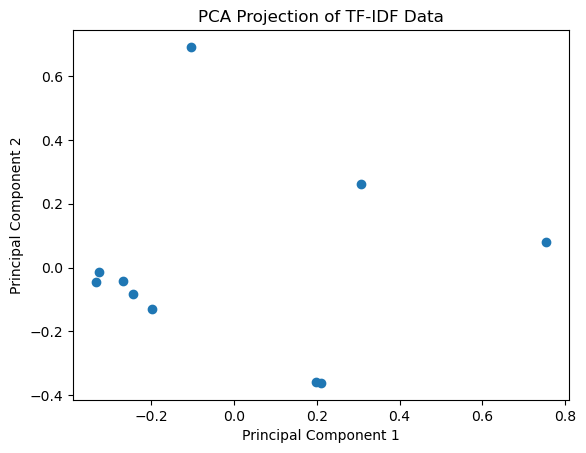

In [12]:
# Analyse de la répartition des données
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(vec_combined)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA Projection of TF-IDF Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
optimal_n_components = n_components_range[np.argmin(log_likelihoods)]
optimal_n_components

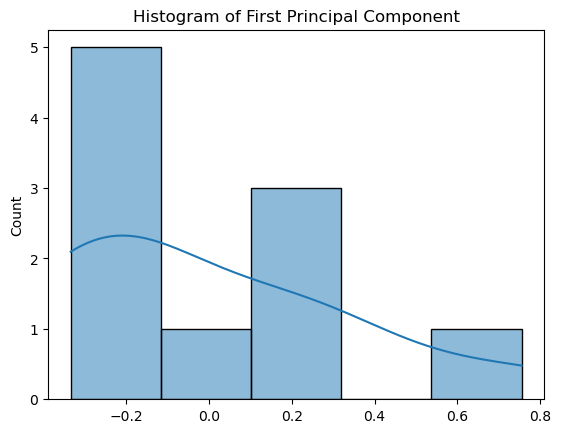

In [13]:
# Plot histograms of the principal components
sns.histplot(reduced_data[:, 0], kde=True)
plt.title('Histogram of First Principal Component')
plt.show()

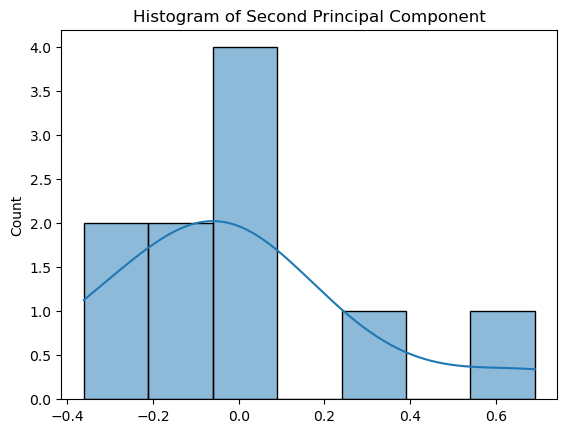

In [14]:
sns.histplot(reduced_data[:, 1], kde=True)
plt.title('Histogram of Second Principal Component')
plt.show()


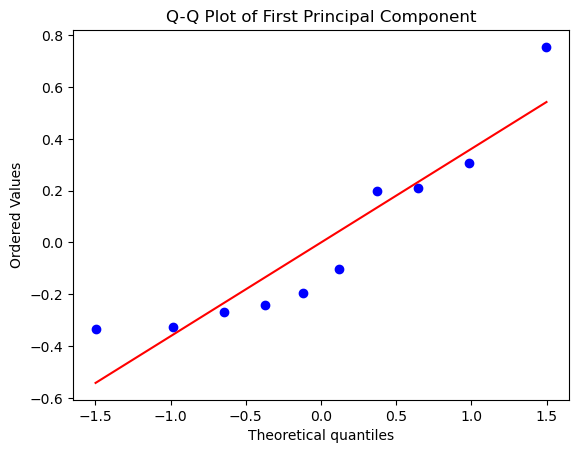

In [15]:
# Q-Q plots
import scipy.stats as stats
stats.probplot(reduced_data[:, 0], dist="norm", plot=plt)
plt.title('Q-Q Plot of First Principal Component')
plt.show()

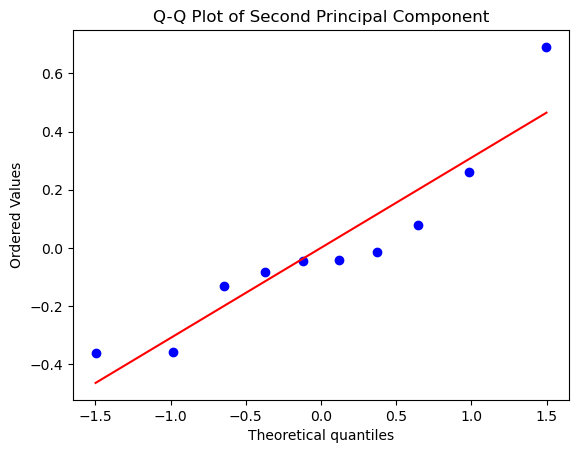

In [16]:
stats.probplot(reduced_data[:, 1], dist="norm", plot=plt)
plt.title('Q-Q Plot of Second Principal Component')
plt.show()

In [17]:
# Kolmogorov-Smirnov test for normality
stat1, p1 = kstest(reduced_data[:, 0], 'norm', args=(reduced_data[:, 0].mean(), reduced_data[:, 0].std()))
stat2, p2 = kstest(reduced_data[:, 1], 'norm', args=(reduced_data[:, 1].mean(), reduced_data[:, 1].std()))
print(f'Kolmogorov-Smirnov Test for First Principal Component: Statistics={stat1}, p-value={p1}')
print(f'Kolmogorov-Smirnov Test for Second Principal Component: Statistics={stat2}, p-value={p2}')


Kolmogorov-Smirnov Test for First Principal Component: Statistics=0.21969395517710488, p-value=0.6441980608674431
Kolmogorov-Smirnov Test for Second Principal Component: Statistics=0.22008424556385564, p-value=0.6420891651404059


Both principal components follow a Gaussian distribution. Proceeding with VBGMM.
                                              Author                    Title  \
0  Alexandre Dumas                               ...                  Pauline   
1                   Alexandre Dumas                   Les trois mousquetaires   
2  Alexandre Dumas                               ...          Gabriel Lambert   
3  Alexandre Dumas                               ...        Le comte de Moret   
4  Alexandre Dumas                               ...          La tulipe noire   
5     Alexandre Dumas                                  Creation et redemption   
6    Alexandre Dumas                                    Le capitaine Pamphile   
7  Alexandre Dumas                               ...                     Acte   
8        Alexandre Dumas, Pere                                La reine Margot   
9   Alexandre Dumas, Pere                                Henri III et sa Cour   

   Year                    

/tmp/ipykernel_13290/265356723.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = labels


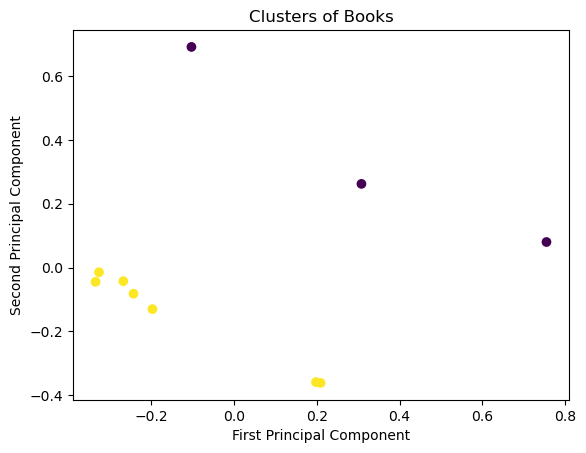

In [19]:
# Check if p-values are greater than 0.05 (common threshold)
df = df[:10]
if p1 > 0.05 and p2 > 0.05:
    print("Both principal components follow a Gaussian distribution. Proceeding with VBGMM.")
    
    # Create a VBGMM model
    vbgmm = BayesianGaussianMixture(n_components=3, covariance_type='full')
    
    # Fit the model to the data
    vbgmm.fit(reduced_data)
    
    # Predict the cluster for each sample
    labels = vbgmm.predict(reduced_data)
    
    df['Cluster'] = labels
    print(df)
    
    # Plot the clusters
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title('Clusters of Books')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
else:
    print("One or both principal components do not follow a Gaussian distribution. Consider transforming the data or using a different model.")

In [21]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for n in range(2, 10):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42).fit(vec_combined)
    labels = gmm.predict(vec_combined)
    score = silhouette_score(vec_combined, labels)
    print(score)
    silhouette_scores.append(score)
optimal_n = range(2, 10)[silhouette_scores.index(max(silhouette_scores))]

KeyboardInterrupt: 